# Sentiment analysis

## Loading files & dependency

In [59]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import gc

In [1]:
import os
import json
import random
from pathlib import Path
from zipfile import ZipFile

In [2]:
!pip3 install seaborn

In [33]:
!pip3 install wordcloud

     |████████████████████████████████| 220 kB 4.7 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp39-cp39-macosx_10_9_x86_64.whl size=154359 sha256=e77c32419aebd71da5c07c14a02eab25c58820388dd8ed0440db18f64bcf1ecb
  Stored in directory: /Users/florent-haffner/Library/Caches/pip/wheels/f9/7a/dd/06ef8b5dfe5483f6204133c08eeb16c287cc2c05e290ae2fc0
Successfully built wordcloud


In [6]:
!pip3 install textblob textblob_fr

In [7]:
!pip3 install plotly

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

In [4]:
import string
import re

In [5]:
# pd.set_option('max_colwidth', None)

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize

import spacy
from spacy.lang.fr.stop_words import STOP_WORDS

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

import plotly.graph_objects as go
import plotly.express as px

In [9]:
df = pd.read_csv('../../Resources/communes_commentaire.csv', delimiter=';'); df.head()

,Insee,Code_postal,Ville,Sécurité,Éducation,Sport / Loisir,Environnement,Vie pratique,pouce_positif,pouce_negatif,commentaire,date,auteur
0,1004,1500,Ambérieu-en-Bugey,5.0,4.0,5.0,5.0,4.0,2,0,"Ville très agréable, tranquille et disposant d...",15/05/2021,INNO
1,1004,1500,Ambérieu-en-Bugey,4.0,4.0,4.0,4.0,3.0,0,1,La police et la gendarmerie peuvent se montrer...,03/03/2021,Jane
2,1004,1500,Ambérieu-en-Bugey,5.0,5.0,4.0,4.0,4.0,0,0,Ville ou sa ne vis pas beaucoup,04/11/2020,lilalou
3,1004,1500,Ambérieu-en-Bugey,2.0,4.0,2.0,4.0,2.0,0,0,C’est une belle ville mais peu d’activités (sp...,20/08/2019,Le tounsi
4,1004,1500,Ambérieu-en-Bugey,4.0,2.0,3.0,3.0,3.0,0,0,"Aspects positifs: la mixité sociale, cohabitat...",13/04/2018,Laetitialexandre


In [10]:
data = df.copy()
data.shape

(24344, 13)

In [11]:
NAN = [(c, data[c].isna().mean()*100) for c in data]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
3,Sécurité,2.805619
4,Éducation,2.805619
5,Sport / Loisir,2.805619
6,Environnement,2.805619
7,Vie pratique,2.805619
0,Insee,0.000000
1,Code_postal,0.000000
2,Ville,0.000000
8,pouce_positif,0.000000
9,pouce_negatif,0.000000


In [12]:
data = data.dropna()

In [13]:
data.shape

(23661, 13)

In [14]:
NAN = [(c, data[c].isna().mean()*100) for c in data]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
0,Insee,0.0
1,Code_postal,0.0
2,Ville,0.0
3,Sécurité,0.0
4,Éducation,0.0
5,Sport / Loisir,0.0
6,Environnement,0.0
7,Vie pratique,0.0
8,pouce_positif,0.0
9,pouce_negatif,0.0


## Data processing

In [15]:
data['Comment'] = data['commentaire'].apply(lambda f: f.lower())

In [16]:
AComment=[]
for comment in data["Comment"].apply(str):
    Word_Tok = []
    for word in  re.sub("\W"," ",comment ).split():
        Word_Tok.append(word)
    AComment.append(Word_Tok)

In [17]:
data["Word_Tok"] = AComment
data.head(5)

,Insee,Code_postal,Ville,Sécurité,Éducation,Sport / Loisir,Environnement,Vie pratique,pouce_positif,pouce_negatif,commentaire,date,auteur,Comment,Word_Tok
0,1004,1500,Ambérieu-en-Bugey,5.0,4.0,5.0,5.0,4.0,2,0,"Ville très agréable, tranquille et disposant d...",15/05/2021,INNO,"ville très agréable, tranquille et disposant d...","[ville, très, agréable, tranquille, et, dispos..."
1,1004,1500,Ambérieu-en-Bugey,4.0,4.0,4.0,4.0,3.0,0,1,La police et la gendarmerie peuvent se montrer...,03/03/2021,Jane,la police et la gendarmerie peuvent se montrer...,"[la, police, et, la, gendarmerie, peuvent, se,..."
2,1004,1500,Ambérieu-en-Bugey,5.0,5.0,4.0,4.0,4.0,0,0,Ville ou sa ne vis pas beaucoup,04/11/2020,lilalou,ville ou sa ne vis pas beaucoup,"[ville, ou, sa, ne, vis, pas, beaucoup]"
3,1004,1500,Ambérieu-en-Bugey,2.0,4.0,2.0,4.0,2.0,0,0,C’est une belle ville mais peu d’activités (sp...,20/08/2019,Le tounsi,c’est une belle ville mais peu d’activités (sp...,"[c, est, une, belle, ville, mais, peu, d, acti..."
4,1004,1500,Ambérieu-en-Bugey,4.0,2.0,3.0,3.0,3.0,0,0,"Aspects positifs: la mixité sociale, cohabitat...",13/04/2018,Laetitialexandre,"aspects positifs: la mixité sociale, cohabitat...","[aspects, positifs, la, mixité, sociale, cohab..."


In [18]:
stop_words=set(STOP_WORDS)

# deselect_stop_words = ['n\'', 'ne','pas','plus','personne','aucun','ni','aucune','rien']
# for w in deselect_stop_words:
#     if w in stop_words:
#         stop_words.remove(w)
#     else:
#         continue

In [19]:
AllfilteredComment=[]
for comment in data["Word_Tok"]:
    filteredComment = [w for w in comment if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredComment.append(' '.join(filteredComment))

In [20]:
data["CommentAferPreproc"]=AllfilteredComment
data.head(5)

,Insee,Code_postal,Ville,Sécurité,Éducation,Sport / Loisir,Environnement,Vie pratique,pouce_positif,pouce_negatif,commentaire,date,auteur,Comment,Word_Tok,CommentAferPreproc
0,1004,1500,Ambérieu-en-Bugey,5.0,4.0,5.0,5.0,4.0,2,0,"Ville très agréable, tranquille et disposant d...",15/05/2021,INNO,"ville très agréable, tranquille et disposant d...","[ville, très, agréable, tranquille, et, dispos...",ville agréable tranquille disposant commodités...
1,1004,1500,Ambérieu-en-Bugey,4.0,4.0,4.0,4.0,3.0,0,1,La police et la gendarmerie peuvent se montrer...,03/03/2021,Jane,la police et la gendarmerie peuvent se montrer...,"[la, police, et, la, gendarmerie, peuvent, se,...",police gendarmerie montrer trop répressives in...
2,1004,1500,Ambérieu-en-Bugey,5.0,5.0,4.0,4.0,4.0,0,0,Ville ou sa ne vis pas beaucoup,04/11/2020,lilalou,ville ou sa ne vis pas beaucoup,"[ville, ou, sa, ne, vis, pas, beaucoup]",ville vis beaucoup
3,1004,1500,Ambérieu-en-Bugey,2.0,4.0,2.0,4.0,2.0,0,0,C’est une belle ville mais peu d’activités (sp...,20/08/2019,Le tounsi,c’est une belle ville mais peu d’activités (sp...,"[c, est, une, belle, ville, mais, peu, d, acti...",belle ville activités sportifs divertissante
4,1004,1500,Ambérieu-en-Bugey,4.0,2.0,3.0,3.0,3.0,0,0,"Aspects positifs: la mixité sociale, cohabitat...",13/04/2018,Laetitialexandre,"aspects positifs: la mixité sociale, cohabitat...","[aspects, positifs, la, mixité, sociale, cohab...",aspects positifs mixité sociale cohabitation h...


In [21]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

for i in data['CommentAferPreproc'][:10]:
    sentiment = tb(i).sentiment
    polarity = tb(i).polarity
    print(i, sentiment)

ville agréable tranquille disposant commodités commerces écoles gare clubs sport clinique ville trop loin lyon pied montagnes profiter nature (0.2125, 0.5)
police gendarmerie montrer trop répressives infractions stationnements conciliantes zones véhicules bref poids mesures difficile accepter (-0.1925, 0.275)
ville vis beaucoup (0.1, 0.1)
belle ville activités sportifs divertissante (0.45, 0.5)
aspects positifs mixité sociale cohabitation habitants mélange culture accès culture quartiers défavorisés aspects négatifs choses proposés faible cout (-0.043333333333333335, 0.16666666666666666)
ville province trop incivilités beaucoup choses faites transport personnes maison medicalisées bien (-0.049999999999999996, 0.3333333333333333)
bonne commune tri déchets rues propres écoles neuves manque commerce (0.3025, 0.325)
prêt partir ville (0.14, 0.15)
positif belles forêts beaux lacs loin négatif animation centre ville animé mort (0.5333333333333333, 0.5333333333333333)
petite ville sympathique

In [22]:
senti_list = []
for i in data["CommentAferPreproc"]:
    vs = tb(i).sentiment[0]
    if (vs > 0.2):
        senti_list.append('Positive')
    elif (vs < -0.2):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral')

In [23]:
data["sentiment"] = senti_list

1. Computing mean scoring
2. Computing confusion matrix

## Analysing data based on sentiment

In [24]:
nb_pos=np.sum(data['sentiment']=='Positive')
nb_neg=np.sum(data['sentiment']=='Negative')
nb_neutral = np.sum(data['sentiment']=='Neutral')

print(f'Positive: {nb_pos*100/len(data):.2f}%, negative: {nb_neg*100/len(data):.2f}%, neutre: {nb_neutral*100/len(data):.2f}%')

Positive: 47.31%, negative: 4.13%, neutre: 48.56%


([<matplotlib.patches.Wedge at 0x7fbfb8e3b4c0>,
 [Text(0.049859869302626356, 1.0988694160058898, 'Neutral'),
  Text(-0.19173214521523518, -1.0831614766465636, 'Positive'),
  Text(1.090738866802826, -0.14243849355313778, 'Negative')])

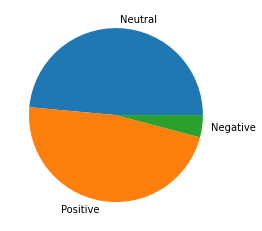

In [25]:
plt.pie(data['sentiment'].value_counts()*100/len(data), 
        labels=['Neutral', 'Positive', 'Negative'])

In [37]:
positive = data.query('sentiment == "Positive"'); positive[['Ville', 'commentaire']].head(5)

,Ville,commentaire
0,Ambérieu-en-Bugey,"Ville très agréable, tranquille et disposant d..."
3,Ambérieu-en-Bugey,C’est une belle ville mais peu d’activités (sp...
6,Ambérieux-en-Dombes,Très bonne commune mais pas de tri des déchets...
8,Arbent,Positif : de belles forêts et beaux lacs pas l...
9,Arboys en Bugey,Petite ville sympathique dotée de toutes les c...


In [38]:
neutral = data.query('sentiment == "Neutral"'); neutral[['Ville', 'commentaire']].head(5)

,Ville,commentaire
1,Ambérieu-en-Bugey,La police et la gendarmerie peuvent se montrer...
2,Ambérieu-en-Bugey,Ville ou sa ne vis pas beaucoup
4,Ambérieu-en-Bugey,"Aspects positifs: la mixité sociale, cohabitat..."
5,Ambérieu-en-Bugey,"Ville de province, sans trop d'incivilités. Be..."
7,Ambronay,Je ne suis pas prêt de partir de ma ville


In [39]:
negative = data.query('sentiment == "Negative"'); negative[['Ville', 'commentaire']].head(5)

,Ville,commentaire
25,Valserhône,Catastrophe
28,Valserhône,"Bellegarde, c'est la ville du quart monde, il ..."
134,Jasseron,Pas assez de commerce. Habitants désagréables....
195,Oyonnax,"Ville très très dangereuse, rien en magasin, m..."
217,Pont-de-Veyle,C'est un village proche d'une ville difficile ...


In [29]:
data['score_estimation'] = data[['Sécurité', 'Éducation', 'Sport / Loisir', 'Environnement', 'Vie pratique']].mean(axis=1)

### Confusion matrix

In [30]:
confusion_matrix = pd.crosstab(data['score_estimation'], data['sentiment'], rownames=['Actual'], colnames=['Predicted'])

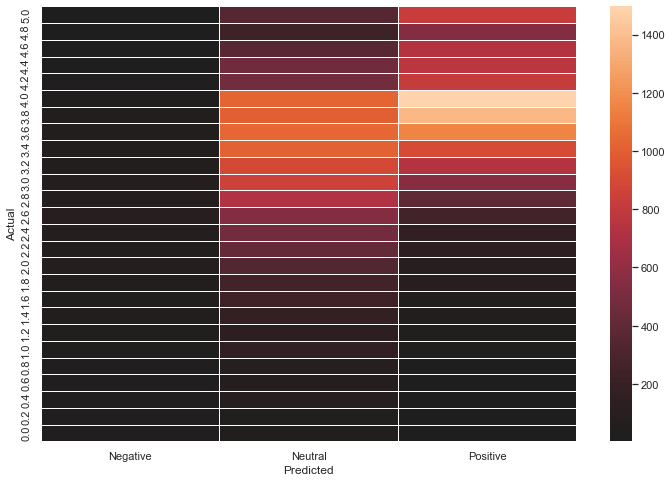

In [31]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.heatmap(confusion_matrix.sort_index(ascending=False), 
            linewidths=.5, center=0,
            xticklabels=['Negative', 'Neutral', 'Positive'])
plt.show()

### Words cloud per types of sentiment

In [34]:
from wordcloud import WordCloud
from PIL import Image

In [101]:
def generate_word(df, nbr_words):
    df_word_frequency = df.CommentAferPreproc.str.split(expand=True).stack().value_counts().reset_index() 
    df_word_frequency.columns = ['Word', 'Frequency']

    words_list = df_word_frequency[:nbr_words]['Word']
    words_str = ' '.join(str(e) for e in list(words_list))
    wordcloud = WordCloud(background_color = 'black', stopwords = STOP_WORDS, max_words = 50).generate(words_str)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

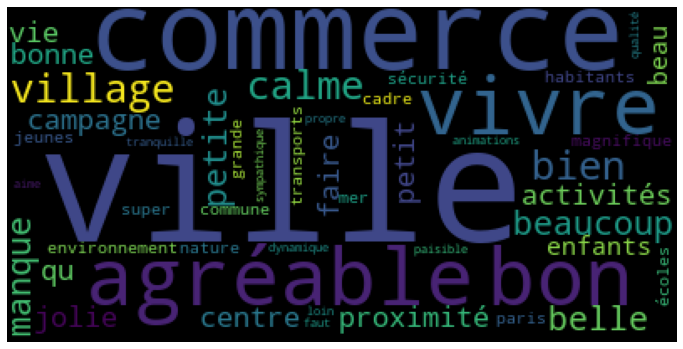

In [102]:
generate_word(positive, 50)

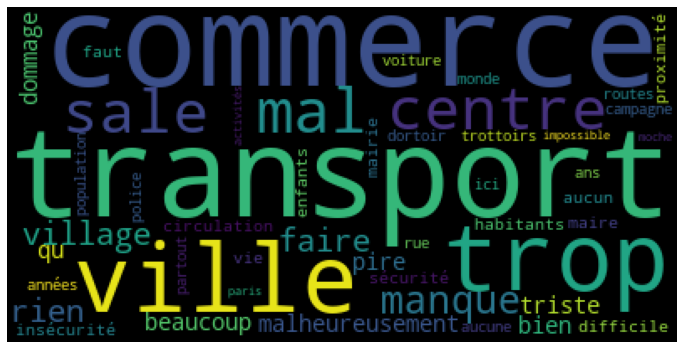

In [103]:
generate_word(negative, 50)

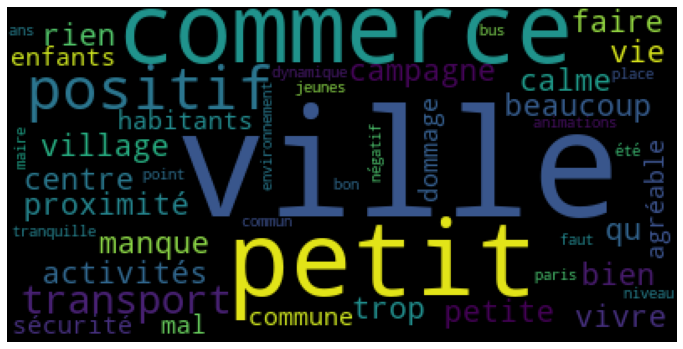

In [104]:
generate_word(neutral, 50)